In [1]:
from statsmodels.stats.proportion import proportions_ztest
from google.cloud import bigquery
import pandas as pd, numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

project = "sql-ab-portfolio" 
dataset = "instacart"

client = bigquery.Client(project=project)
print("BigQuery client ready:", client.project)

/Users/noorkamal/Documents/GitHub/ab-sql-instacart/.abenv/lib/python3.11/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


BigQuery client ready: sql-ab-portfolio


In [2]:
# check counts in tables 
sql = f"""
SELECT
  (SELECT COUNT(*) FROM `{project}.{dataset}.assignments`)   AS assignments_rows,
  (SELECT COUNT(*) FROM `{project}.{dataset}.user_outcomes`) AS outcomes_rows,
  (SELECT COUNT(*) FROM `{project}.{dataset}.variant_metrics`) AS metrics_rows
"""
client.query(sql).to_dataframe()

/Users/noorkamal/Documents/GitHub/ab-sql-instacart/.abenv/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,assignments_rows,outcomes_rows,metrics_rows
0,206209,206209,2


In [3]:
# get metrics from user_outcomes
quick = client.query(f"""
SELECT variant,
       COUNT(*) AS users,
       AVG(converted) AS conversion_28d,
       AVG(retained_d14) AS retention_14d,
       AVG(items_in_window) AS arpu_proxy
FROM `{project}.{dataset}.user_outcomes`
GROUP BY variant
ORDER BY variant
""").to_dataframe()
quick

/Users/noorkamal/Documents/GitHub/ab-sql-instacart/.abenv/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,variant,users,conversion_28d,retention_14d,arpu_proxy
0,A,103523,0.408132,0.322498,9.833776
1,B,102686,0.408040,0.321923,9.815282


In [4]:
# redo statistical tests
# z-test for conversion and day 14 retention

def ztest_metric(metric: str):
    q = f"""
    SELECT variant, SUM({metric}) AS success, COUNT(*) AS n
    FROM `{project}.{dataset}.user_outcomes`
    GROUP BY variant
    """
    
    g = client.query(q).to_dataframe().set_index('variant')

    count = np.array([g.loc['B','success'], g.loc['A','success']])
    nobs  = np.array([g.loc['B','n'],       g.loc['A','n']])
    stat, pval = proportions_ztest(count, nobs, alternative='two-sided')
    
    p_b = g.loc['B','success']/g.loc['B','n']
    p_a = g.loc['A','success']/g.loc['A','n']
    
    return {
        'metric': metric,
        'A': p_a, 'B': p_b,
        'diff': p_b - p_a,
        'z': float(stat),
        'p': float(pval)
    }

for m in ['converted','retained_d14']:
    print(ztest_metric(m))

/Users/noorkamal/Documents/GitHub/ab-sql-instacart/.abenv/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


{'metric': 'converted', 'A': np.float64(0.4081315263274828), 'B': np.float64(0.408040044407222), 'diff': np.float64(-9.148192026076085e-05), 'z': -0.04226203036655021, 'p': 0.9662898136047766}
{'metric': 'retained_d14', 'A': np.float64(0.32249838200206715), 'B': np.float64(0.3219231443429484), 'diff': np.float64(-0.0005752376591187658), 'z': -0.27947938347626977, 'p': 0.7798769575328888}


In [5]:
# run t-test for average revenue per user (ARPU)

sql_arpu = f"SELECT variant, items_in_window FROM `{project}.{dataset}.user_outcomes`"

df_arpu = client.query(sql_arpu).to_dataframe()

a = df_arpu.loc[df_arpu.variant=='A','items_in_window']
b = df_arpu.loc[df_arpu.variant=='B','items_in_window']

t, p = stats.ttest_ind(b, a, equal_var=False) 

print({'mean_A':a.mean(), 'mean_B':b.mean(), 'diff': b.mean()-a.mean(), 't': t, 'p': p})

{'mean_A': np.float64(9.833776069086097), 'mean_B': np.float64(9.815281537892215), 'diff': np.float64(-0.018494531193882224), 't': np.float64(-0.20470514203789272), 'p': np.float64(0.8378027047671557)}


Generate 95% confidence intervals for differences in conversion and ARPU by resampling users

In [7]:
rng = np.random.default_rng(42)

# get metrics from Bigquery
df = client.query(f"""
  SELECT variant, items_in_window AS arpu_proxy, converted, retained_d14
  FROM `{project}.{dataset}.user_outcomes`
""").to_dataframe()

a_arpu = df.loc[df.variant=='A','arpu_proxy'].to_numpy()
b_arpu = df.loc[df.variant=='B','arpu_proxy'].to_numpy()

a_conv = df.loc[df.variant=='A','converted'].to_numpy().astype(int)
b_conv = df.loc[df.variant=='B','converted'].to_numpy().astype(int)

len(a_arpu), len(b_arpu), a_conv.mean(), b_conv.mean()

/Users/noorkamal/Documents/GitHub/ab-sql-instacart/.abenv/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


(103523, 102686, np.float64(0.4081315263274828), np.float64(0.408040044407222))

In [8]:
# Boostrap mean differences in ARPU 
def bootstrap_diff_mean(a, b, B=2000, seed=None):
    """Return (point_estimate, (lo, hi), samples) for mean(B) - mean(A)."""
    rng = np.random.default_rng(seed)
    diffs = np.empty(B, dtype=float)
    na, nb = len(a), len(b)
    for i in range(B):
        ai = rng.choice(a, size=na, replace=True)
        bi = rng.choice(b, size=nb, replace=True)
        diffs[i] = bi.mean() - ai.mean()
    lo, hi = np.percentile(diffs, [2.5, 97.5])
    return float(diffs.mean()), (float(lo), float(hi)), diffs

In [9]:
arpu_diff, arpu_ci, arpu_samples = bootstrap_diff_mean(a_arpu, b_arpu, B=4000, seed=123)

In [10]:
print({
    "metric": "ARPU (items per user)",
    "diff_B_minus_A": arpu_diff,
    "ci_95": arpu_ci
})

{'metric': 'ARPU (items per user)', 'diff_B_minus_A': -0.01778358384635648, 'ci_95': (-0.1897050282727434, 0.1617552870522547)}


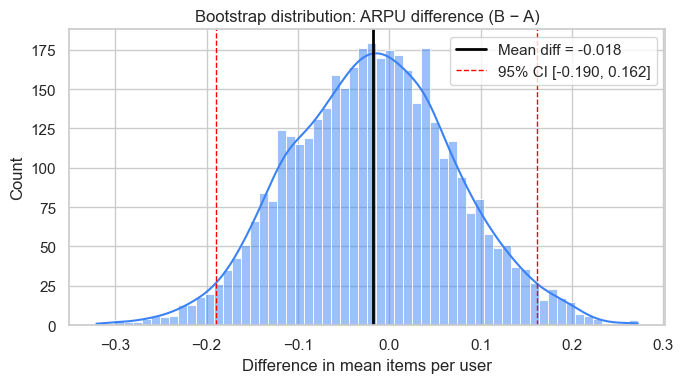

In [11]:
# Plot distribution 
sns.set(style="whitegrid")
plt.figure(figsize=(7,4))
sns.histplot(arpu_samples, bins=60, kde=True, color="#3b82f6")
plt.axvline(arpu_diff, color="black", lw=2, label=f"Mean diff = {arpu_diff:.3f}")
plt.axvline(arpu_ci[0], color="red", ls="--", lw=1, label=f"95% CI [{arpu_ci[0]:.3f}, {arpu_ci[1]:.3f}]")
plt.axvline(arpu_ci[1], color="red", ls="--", lw=1)
plt.title("Bootstrap distribution: ARPU difference (B − A)")
plt.xlabel("Difference in mean items per user")
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# Bootstrap differences in proportion - conversion rate 
def bootstrap_diff_prop(a01, b01, B=2000, seed=None):
    """Return (point_estimate, (lo, hi), samples) for p_B - p_A, where inputs are 0/1 arrays."""
    rng = np.random.default_rng(seed)
    diffs = np.empty(B, dtype=float)
    na, nb = len(a01), len(b01)
    for i in range(B):
        ai = rng.choice(a01, size=na, replace=True)
        bi = rng.choice(b01, size=nb, replace=True)
        diffs[i] = bi.mean() - ai.mean()
    lo, hi = np.percentile(diffs, [2.5, 97.5])
    return float(diffs.mean()), (float(lo), float(hi)), diffs

In [13]:
cr_diff, cr_ci, cr_samples = bootstrap_diff_prop(a_conv, b_conv, B=4000, seed=456)

In [14]:
print({
    "metric": "Conversion (28d)",
    "diff_B_minus_A": cr_diff,
    "ci_95": cr_ci
})

{'metric': 'Conversion (28d)', 'diff_B_minus_A': -0.00014141477957000002, 'ci_95': (-0.004401514812065821, 0.004080787434627999)}


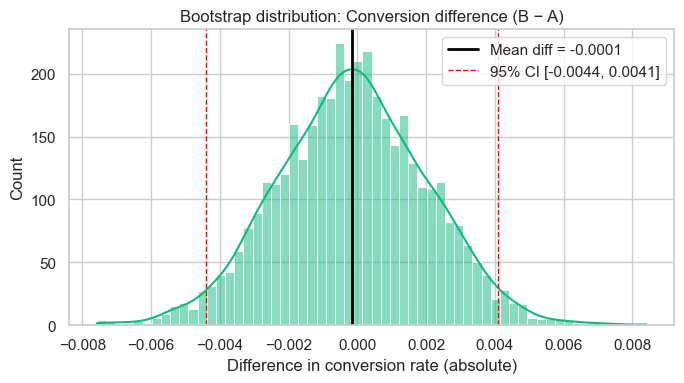

In [15]:
# Plot differences in conversion rates between the two variants
plt.figure(figsize=(7,4))
sns.histplot(cr_samples, bins=60, kde=True, color="#10b981")
plt.axvline(cr_diff, color="black", lw=2, label=f"Mean diff = {cr_diff:.4f}")
plt.axvline(cr_ci[0], color="red", ls="--", lw=1, label=f"95% CI [{cr_ci[0]:.4f}, {cr_ci[1]:.4f}]")
plt.axvline(cr_ci[1], color="red", ls="--", lw=1)
plt.title("Bootstrap distribution: Conversion difference (B − A)")
plt.xlabel("Difference in conversion rate (absolute)")
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# bootstrap for day 14 retention
a_ret = df.loc[df.variant=='A','retained_d14'].to_numpy().astype(int)
b_ret = df.loc[df.variant=='B','retained_d14'].to_numpy().astype(int)

ret_diff, ret_ci, ret_samples = bootstrap_diff_prop(a_ret, b_ret, B=4000, seed=789)

In [17]:
print({
    "metric": "Retention D14",
    "diff_B_minus_A": ret_diff,
    "ci_95": ret_ci
})

{'metric': 'Retention D14', 'diff_B_minus_A': -0.0006216432889455244, 'ci_95': (-0.004663132569905243, 0.003407935414017549)}


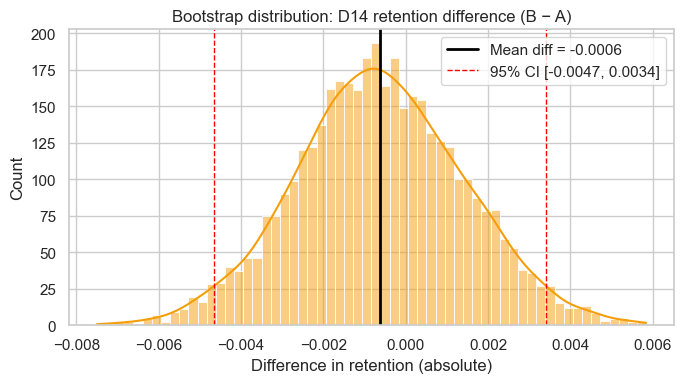

In [18]:
# Plot differences in day 14 retention
plt.figure(figsize=(7,4))
sns.histplot(ret_samples, bins=60, kde=True, color="#f59e0b")
plt.axvline(ret_diff, color="black", lw=2, label=f"Mean diff = {ret_diff:.4f}")
plt.axvline(ret_ci[0], color="red", ls="--", lw=1, label=f"95% CI [{ret_ci[0]:.4f}, {ret_ci[1]:.4f}]")
plt.axvline(ret_ci[1], color="red", ls="--", lw=1)
plt.title("Bootstrap distribution: D14 retention difference (B − A)")
plt.xlabel("Difference in retention (absolute)")
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
summary = pd.DataFrame([
    {"metric": "Conversion (28d)", "diff_B_minus_A": cr_diff,   "ci_low": cr_ci[0],   "ci_high": cr_ci[1]},
    {"metric": "Retention D14",    "diff_B_minus_A": ret_diff,  "ci_low": ret_ci[0],  "ci_high": ret_ci[1]},
    {"metric": "ARPU (items)",     "diff_B_minus_A": arpu_diff, "ci_low": arpu_ci[0], "ci_high": arpu_ci[1]},
])
summary

,metric,diff_B_minus_A,ci_low,ci_high
0,Conversion (28d),-0.000141,-0.004402,0.004081
1,Retention D14,-0.000622,-0.004663,0.003408
2,ARPU (items),-0.017784,-0.189705,0.161755


Confidence intervals for all three metrics are close to zero and very narrow. 
The experiment rules out any meaningful lift from the recommendation engine.

Power & Minimum Detectable Effect (MDE)

In [21]:
# Pull baseline conversion and sample sizes from Bigquery
g = client.query(f"""
SELECT variant, COUNT(*) AS n, AVG(converted) AS cr
FROM `{project}.{dataset}.user_outcomes`
GROUP BY variant
""").to_dataframe().set_index('variant')

p_baseline = g['cr'].mean()
n_a, n_b = int(g.loc['A','n']), int(g.loc['B','n'])

/Users/noorkamal/Documents/GitHub/ab-sql-instacart/.abenv/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [22]:
def mde_two_prop(p, n_a, n_b, alpha=0.05, power=0.80):
    z_alpha = stats.norm.ppf(1 - alpha/2)   # ~1.96 for 95% CI
    z_beta  = stats.norm.ppf(power)         # ~0.84 for 80% power
    se = (p*(1-p)*(1/n_a + 1/n_b))**0.5
    return (z_alpha + z_beta) * se          # absolute lift

In [23]:
mde_abs = mde_two_prop(p_baseline, n_a, n_b, alpha=0.05, power=0.80)
mde_rel = mde_abs / p_baseline

In [24]:
pd.Series({
    "baseline_conversion": p_baseline,
    "n_A": n_a, "n_B": n_b,
    "MDE_abs": mde_abs,                # absolute percentage points (as a proportion)
    "MDE_abs_pp": 100*mde_abs,         # percentage points
    "MDE_rel_%": 100*mde_rel           # relative percent of baseline
})
# can detect lift of 0.4 percentage points

baseline_conversion         0.408086
n_A                    103523.000000
n_B                    102686.000000
MDE_abs                     0.006064
MDE_abs_pp                  0.606441
MDE_rel_%                   1.486063
dtype: float64

CUPED = Controlled-experiment Using Pre-Experiment Data
It’s a statistical trick used in A/B testing to make results more precise (smaller variance, tighter confidence intervals), without changing the mean effect estimate. Helps reduce noise in the experiment.

In [25]:
# first we create a table which captures orders placed by customers BEFORE the date the variant (treatment/control) was assigned
# create a new table which records users and the items they purchased before the assigned_date
sql = f"""
CREATE OR REPLACE TABLE `{project}.{dataset}.preperiod_items` AS

WITH cohort AS (
  SELECT user_id, variant, assigned_at
  FROM `{project}.{dataset}.assignments`
),

pre_orders AS (
  SELECT u.user_id, u.order_id
  FROM `{project}.{dataset}.user_orders_pseudodate` u
  JOIN cohort c USING (user_id)
  WHERE u.pseudo_order_date < c.assigned_at
),

pre_items AS (
  SELECT po.user_id, COUNT(*) AS items_pre
  FROM pre_orders po
  JOIN `{project}.{dataset}.order_products_prior` opp
    ON opp.order_id = po.order_id
  GROUP BY po.user_id
)

SELECT
  a.user_id,
  a.variant,
  a.assigned_at,
  COALESCE(pi.items_pre, 0) AS items_pre
FROM `{project}.{dataset}.assignments` a
LEFT JOIN pre_items pi ON pi.user_id = a.user_id
"""


client.query(sql).result()

In [26]:
# check number of users across variants matches total users
# average number of items bought by users in each variant before variant was assigned
client.query(f"""
SELECT variant,
       COUNT(*) AS users,
       AVG(items_pre) AS avg_items_pre
FROM `{project}.{dataset}.preperiod_items`
GROUP BY variant
""").to_dataframe()

,variant,users,avg_items_pre
0,A,103523,112.940458
1,B,102686,113.111524


In [30]:
# now we need to get metrics/user outcomes for each variant using the pre data
# we already have the user outcomes table that has post metrics 
# join with pre data
sql = f"""
CREATE OR REPLACE TABLE `{project}.{dataset}.user_outcomes_with_pre` AS
SELECT
  uo.user_id,
  uo.variant,
  uo.assigned_at,
  uo.orders_in_window,
  uo.items_in_window,    -- Y: outcome during test
  uo.converted,
  uo.retained_d14,
  pp.items_pre           -- X: covariate from pre-period
FROM `{project}.{dataset}.user_outcomes` AS uo
LEFT JOIN `{project}.{dataset}.preperiod_items` AS pp
  USING (user_id, variant, assigned_at)
"""

client.query(sql).result()

In [31]:
# compare items purchased pre and post
df_check = client.query(f"""
SELECT variant, items_in_window, items_pre
FROM `{project}.{dataset}.user_outcomes_with_pre`
LIMIT 10
""").to_dataframe()

df_check

,variant,items_in_window,items_pre
0,A,0,25
1,A,0,96
2,A,0,27
3,A,0,9
4,A,0,144
5,A,0,11
6,A,0,43
7,A,0,10
8,A,0,4
9,A,0,86


In [32]:
# summary of average items purchased pre and post treatment by variant
df_summary = client.query(f"""
SELECT
  variant,
  COUNT(*) AS users,
  AVG(items_in_window) AS avg_items_window,
  AVG(items_pre) AS avg_items_pre
FROM `{project}.{dataset}.user_outcomes_with_pre`
GROUP BY variant
""").to_dataframe()

df_summary

/Users/noorkamal/Documents/GitHub/ab-sql-instacart/.abenv/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,variant,users,avg_items_window,avg_items_pre
0,A,103523,9.833776,112.940458
1,B,102686,9.815282,113.111524


In [34]:
# pull items purchased data for pre and post
sql = f"""
SELECT variant, items_in_window AS Y, items_pre AS X
FROM `{project}.{dataset}.user_outcomes_with_pre`
"""

df_cuped = client.query(sql).to_dataframe()

In [35]:
# Fill missing pre-period items with 0
df_cuped['X'] = df_cuped['X'].fillna(0.0)

In [36]:
# estimate regression coefficient

X = df_cuped['X'].to_numpy().astype(float)
Y = df_cuped['Y'].to_numpy().astype(float)

varX = np.var(X, ddof=1)
covYX = np.cov(Y, X, ddof=1)[0,1]
theta = covYX / varX if varX > 0 else 0.0

theta

np.float64(0.12197069587390837)

In [37]:
# get adjusted post outcomes based on baseline pre

df_cuped['Y_cuped'] = Y - theta * (X - X.mean())

In [39]:
raw_var = df_cuped.groupby('variant')['Y'].var() # raw variance
adj_var = df_cuped.groupby('variant')['Y_cuped'].var() # adjusted variance

vr = 1 - (adj_var.mean() / raw_var.mean())  # variance reduction %

In [40]:
print("Raw variance:", raw_var.mean())
print("Adjusted variance:", adj_var.mean())
print("Variance reduction (%):", 100*vr)

# huge variance reduction here, 50% less noise in experiment using cupid

Raw variance: 420.79632717127606
Adjusted variance: 211.426846318081
Variance reduction (%): 49.75553904204485


In [41]:
# run t-test again based on adjusted outcomes to see if anything changes 

# raw outcome test
a_raw = df_cuped.loc[df_cuped.variant=='A','Y']
b_raw = df_cuped.loc[df_cuped.variant=='B','Y']
t_raw, p_raw = stats.ttest_ind(b_raw, a_raw, equal_var=False)

# adjusted outcome test
a_adj = df_cuped.loc[df_cuped.variant=='A','Y_cuped']
b_adj = df_cuped.loc[df_cuped.variant=='B','Y_cuped']
t_adj, p_adj = stats.ttest_ind(b_adj, a_adj, equal_var=False)

In [42]:
print({
    "raw_mean_A": a_raw.mean(), "raw_mean_B": b_raw.mean(), "raw_t": t_raw, "raw_p": p_raw,
    "cuped_mean_A": a_adj.mean(), "cuped_mean_B": b_adj.mean(), "cuped_t": t_adj, "cuped_p": p_adj
})

{'raw_mean_A': np.float64(9.833776069086097), 'raw_mean_B': np.float64(9.815281537892215), 'raw_t': np.float64(-0.20470514203789272), 'raw_p': np.float64(0.8378027047671557), 'cuped_mean_A': np.float64(9.844166290337723), 'cuped_mean_B': np.float64(9.80480662529817), 'cuped_t': np.float64(-0.6146046646146371), 'cuped_p': np.float64(0.5388165112793096)}


In [45]:
from numpy.random import default_rng
rng = default_rng(42)

def bootstrap_ci(a, b, B=2000):
    diffs = []
    na, nb = len(a), len(b)
    for _ in range(B):
        ai = rng.choice(a, size=na, replace=True)
        bi = rng.choice(b, size=nb, replace=True)
        diffs.append(bi.mean() - ai.mean())
    lo, hi = np.percentile(diffs, [2.5, 97.5])
    return np.mean(diffs), (lo, hi), diffs

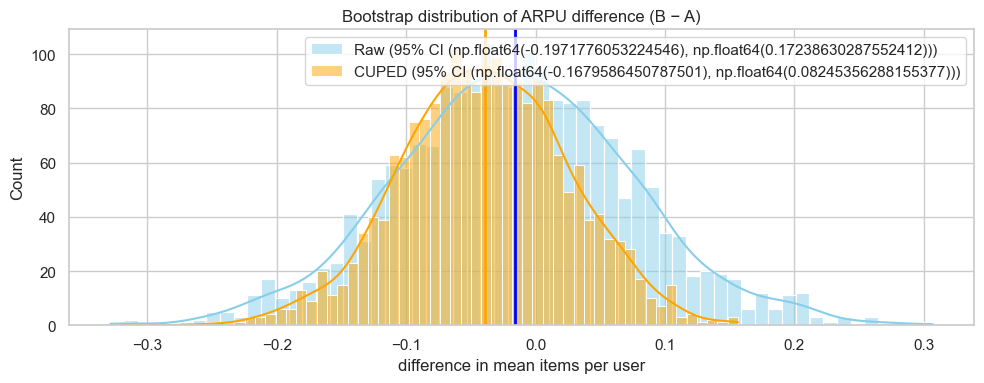

In [47]:
# Bootstrap raw
diff_raw, ci_raw, samples_raw = bootstrap_ci(a_raw, b_raw)
# Bootstrap CUPED
diff_cuped, ci_cuped, samples_cuped = bootstrap_ci(a_adj, b_adj)

# confidence intervals narrowed when using CUPED ARPU
plt.figure(figsize=(10,4))
sns.histplot(samples_raw, bins=60, kde=True, color="skyblue", label=f"Raw (95% CI {ci_raw})")
sns.histplot(samples_cuped, bins=60, kde=True, color="orange", label=f"CUPED (95% CI {ci_cuped})")
plt.axvline(diff_raw, color="blue", lw=2)
plt.axvline(diff_cuped, color="orange", lw=2)
plt.title("Bootstrap distribution of ARPU difference (B − A)")
plt.xlabel("difference in mean items per user")
plt.legend()
plt.tight_layout()
plt.show()